Land cover mapping using machine learning and NAIP
=======================================


## Introduction
In this chapter we will classify the NAIP images using machine learning. Specifically, we will be using [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes). Naive Bayes predicts the probabilities that a data point belongs to a particular class and the class with the highest probability is considered as the most likely class. The way they get these probabilities is by using Bayes’ Theorem, which describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature. Naive Bayes is quite fast when compared to some other machine learning approaches (e.g., SVM can be quite computationally intensive). It is a great first step into the world of machine learning for classification in remote sensing.


## scikit-learn

In this tutorial, we will be using the Naive Bayes implementation provided by the [scikit-learn](http://scikit-learn.org) library. `scikit-learn` is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including `numpy`, `scipy`, and `matplotlib`, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and `scikit-learn` helps you understand this by abstracting the details of each algorithm to simple consistent interfaces.

## Preparing the dataset

Download the lu_phily data from here [link](https://www.dropbox.com/s/ab8qphl7ulvhsrd/lu_phily.tif?dl=0)

Download the NAIP tile here [link](https://www.dropbox.com/s/b8fnjqhdd03kcrl/naip.tif?dl=0)


In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

In [2]:
naip_file = 'output/naip.tif'
naip_dataset = rasterio.open(naip_file)

img_rows, img_cols = naip_dataset.shape
img_bands = naip_dataset.count
print(naip_dataset.shape) # dimensions
print(naip_dataset.count) # bands


(12170, 10292)
3


In [3]:
lu_dataset = rasterio.open('output/lu_philly.tif')
lu_dataset.shape

(50146, 44770)

We need to prepare the NAIP image and the training dataset. In this tutorial, I just use  the existing land cover map in Philadlephia to generate the land cover map and test the accuracy of the image classification method. 

In [4]:
import gdal
import os, os.path


lu_tile = 'data/lu_training2.tif'

lu_gdal = gdal.Open(lu_tile)
naip_gdal = gdal.Open(naip_file)

# originX = geotransform[0], originY = geotransform[3]
# pixelWidth = geotransform[1], pixelHeight = geotransform[5]
lu_transform = lu_gdal.GetGeoTransform()
naip_transform = naip_gdal.GetGeoTransform()

# the right and bottom limit of the land use raster and naip rasters
luMaxX = lu_transform[0] + (lu_transform[1] * lu_gdal.RasterXSize)
luMinY = lu_transform[3] + (lu_transform[5] * lu_gdal.RasterYSize)

# get the right and bottom limit of the napi raster
naipMaxX = naip_transform[0] + (naip_transform[1] * naip_gdal.RasterXSize)
naipMinY = naip_transform[3] + (naip_transform[5] * naip_gdal.RasterYSize)

In [5]:
lu_transform

(2686081.4999, 2.0, 0.0, 253841.1693, 0.0, -2.0)

In [6]:
lu_gdal.RasterYSize

1933

### by comparing different boundaries and find overlaped area on each raster


In [7]:
xstart = max(lu_transform[0], naip_transform[0])
xend = min(luMaxX, naipMaxX)
ydown = max(luMinY, naipMinY)
ytop= min(lu_transform[3], naip_transform[3])


# get the xoff, yoff for two rasters
lu_xoff = int((xstart - lu_transform[0])/lu_transform[1])
lu_yoff = int((ytop - lu_transform[3])/lu_transform[5])
naip_xoff = int((xstart - naip_transform[0])/naip_transform[1])
naip_yoff = int((ytop - naip_transform[3])/naip_transform[5])

# the number of cols and rows of the overlaped area in pixels
cols = int((xend - xstart)/lu_transform[1])
rows = int((ydown - ytop)/lu_transform[5])

# based on the offs and row, cols to read pixel information
lu_img = lu_gdal.ReadAsArray(lu_xoff, lu_yoff, cols, rows) # read the larger raster
naip_img = naip_gdal.ReadAsArray(naip_xoff, naip_yoff, cols, rows)


### Check what the land cover map look like

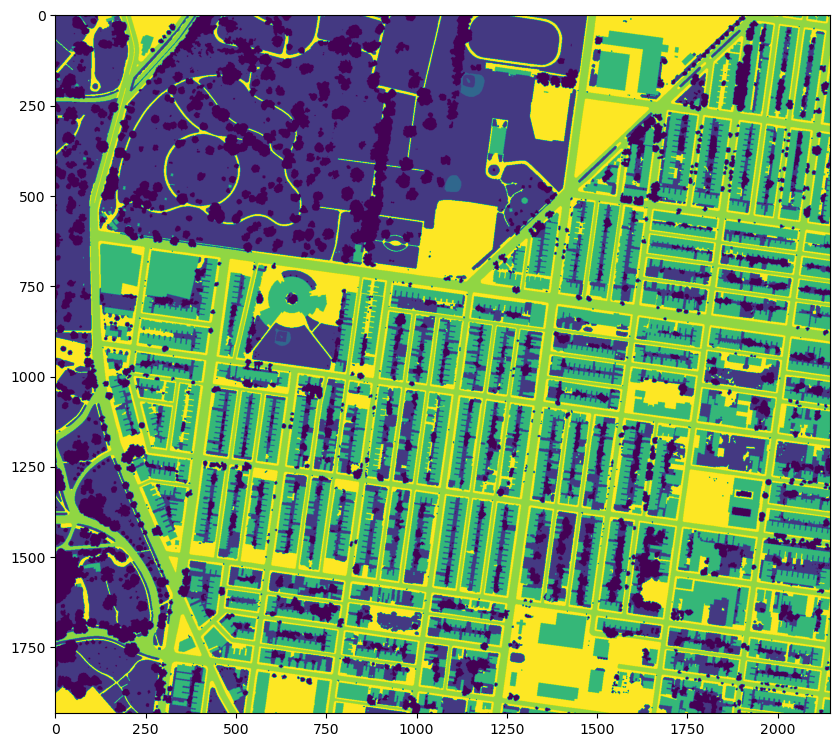

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(lu_img)

### Check the corresponding NAIP images

In [9]:
naip_img.shape

(3, 1933, 2146)

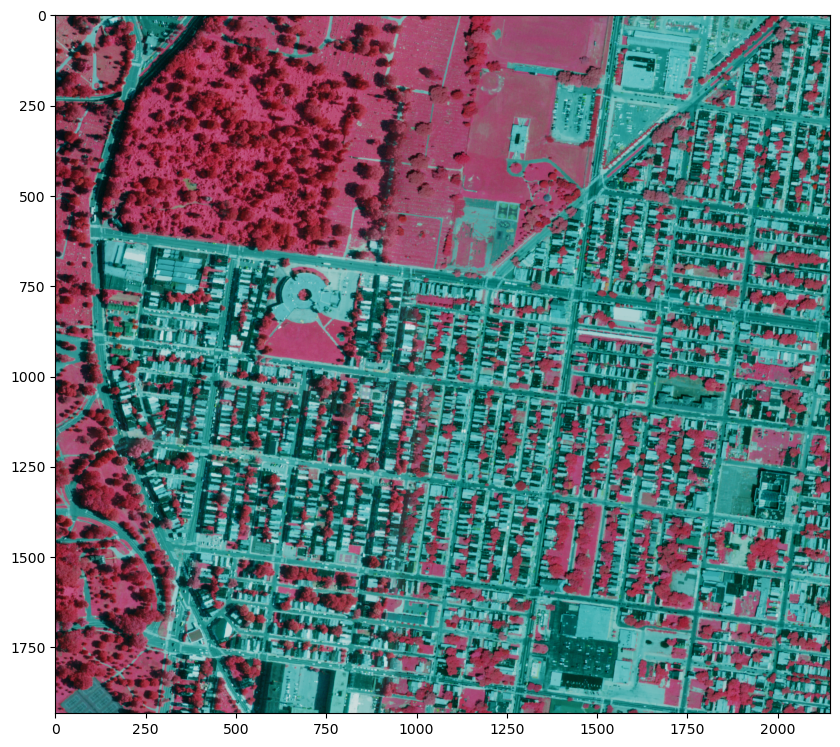

In [10]:
band, row, col = naip_img.shape
plt.figure(figsize=(10, 10))

# the plt.imshow only be able to show the row, col, and band, using moveaxis to switch the axis
plt.imshow(np.moveaxis(naip_img, 0, 2))

### Building the Training Data for `scikit-learn`. Prepare the X (the raster data) and the label vector.
Now let's do it for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

In [11]:
X = np.array([], dtype=np.int8).reshape(0,3) # pixels for training #four bands
y = np.array([], dtype=np.string_) # labels for training


classes = np.unique(lu_img)
for i in classes:
    print('The class is:', i)
    
    # find all the pixels that of different land use classes
    idx = np.where(lu_img == i)
    
    b1 = naip_img[0,:][idx]
    b2 = naip_img[1,:][idx]
    b3 = naip_img[2,:][idx]
    
    lu_naip_pixels = np.stack((b1, b2, b3))
    
    lu_naip_pixels_reshaped = lu_naip_pixels.reshape(-1, 3) #three bands
    
    y = np.append(y, [i] * lu_naip_pixels_reshaped.shape[0]) 
    # stack the pizels onto the pixel array
    X = np.vstack((X,lu_naip_pixels_reshaped))   
    

The class is: 1
The class is: 2
The class is: 3
The class is: 5
The class is: 6
The class is: 7


In [12]:
X.shape, y.shape

((4148218, 3), (4148218,))

#### Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the land cover labels (our y labeled data), let's check to make sure they match in size so we can feed them to Naive Bayes:

In [13]:
# We will need a "X" matrix containing our features, and a "y" array containing our labels
print(f'Our X matrix is sized: {X.shape}')
print(f'Our y array is sized: {y.shape}')

Our X matrix is sized: (4148218, 3)
Our y array is sized: (4148218,)


### Train the model

In [14]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

/home/lee/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GaussianNB()

Let's make a quick helper function, this one will convert the class labels into indicies and then assign a dictionary relating the class indices and their names.

In [15]:
def str_class_to_int(class_array):
    class_array[class_array == 'Other'] = 0
    class_array[class_array == 'Tree'] = 1
    class_array[class_array == 'Grass'] = 2
    class_array[class_array == 'Sand'] = 3
    class_array[class_array == 'Water'] = 4
    class_array[class_array == 'Building'] = 5
    class_array[class_array == 'Road'] = 6
    class_array[class_array == 'Vacant'] = 7
    return(class_array.astype(int))

## Predicting on the image

With our Naive Bayes classifier fit, we can now proceed by trying to classify the entire image:

We're only going to open the subset of the image we viewed above because otherwise it is computationally too intensive for most users.

In [16]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

Now we can predict for each pixel in our image:

In [17]:
with rasterio.open('data/testimg.tif') as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(3, 1028, 1214)
(1028, 1214, 3)


In [18]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 3))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [19]:
type(class_prediction)
class_prediction

array([[b'2', b'2', b'2', ..., b'2', b'2', b'2'],
       [b'2', b'2', b'2', ..., b'2', b'2', b'2'],
       [b'2', b'2', b'2', ..., b'2', b'2', b'2'],
       ...,
       [b'2', b'2', b'2', ..., b'5', b'5', b'2'],
       [b'2', b'2', b'2', ..., b'5', b'5', b'2'],
       [b'2', b'2', b'5', ..., b'5', b'2', b'2']], dtype='|S1')

Because our shapefile came with the labels as strings we want to convert them to a numpy array with ints using the helper function we made earlier.

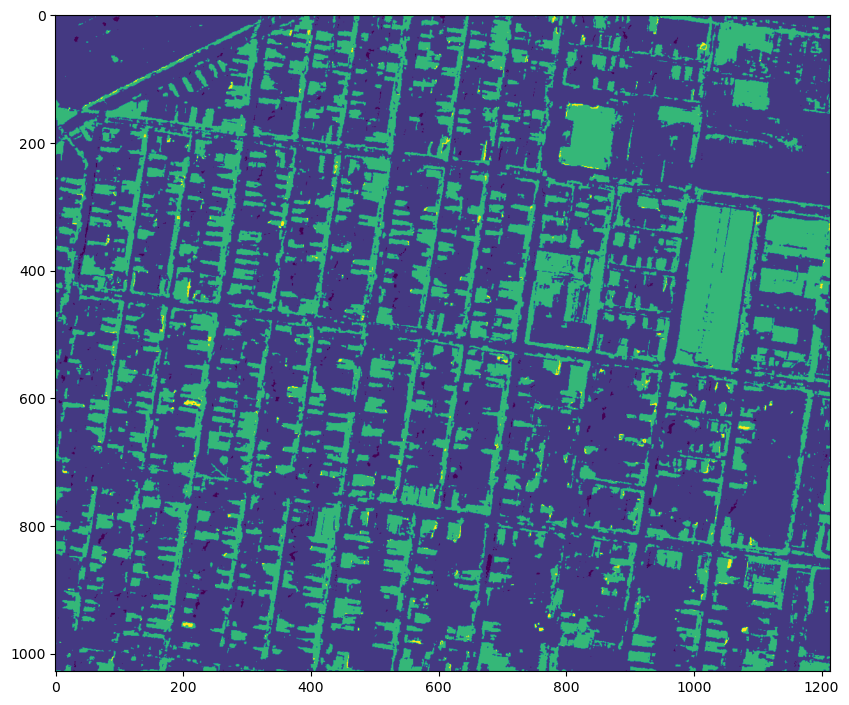

In [20]:
class_prediction = str_class_to_int(class_prediction)

plt.figure(figsize=(10, 10))
plt.imshow(class_prediction)